<a href="https://colab.research.google.com/github/Suravarapu42/Ensemble-Technique/blob/main/EasyVisa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install xgboost


In [3]:
#libraries to read and manipulate data
import numpy as np
import pandas as pd

#libraries to visualize data
import matplotlib.pyplot as plt
import seaborn as sns

#libraries for model building and tuning
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (BaggingClassifier,RandomForestClassifier,
                              GradientBoostingClassifier, AdaBoostClassifier, StackingClassifier)
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

#libraries for metrics and statistics
from sklearn import metrics
import scipy.stats as stats
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score, roc_auc_score

import warnings
warnings.filterwarnings('ignore')


In [8]:
# read the data
df = pd.read_csv('/content/sample_data/EasyVisa.csv')

In [9]:
#format numeric data for easier readability
pd.set_option(
    "display.float_format", lambda x: "%.2f" % x
)  # to display numbers rounded off to 2 decimal places

In [10]:
# function to create labeled barplots

def labeled_barplot(data, feature, feature_2, order, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    feature_2: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    ax = sns.countplot(
        data=data,
        x=feature,
        palette='viridis',
        order=order,
        hue=feature_2,
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=9,
            xytext=(0, 5),
            textcoords="offset points"
        )  # annotate the percentage

    plt.show()  # show the plot

In [11]:
# function to plot a boxplot and a histogram along the same scale

def histogram_boxplot(data, feature, figsize=(16, 6), kde=False, bins=None, hue=None):
    """
    Combines boxplot and histogram

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (16,6))
    kde: whether to show the density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True,
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter",
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

In [12]:
# function to plot stacked bar chart

def stacked_barplot(data, predictor, target):
    """
    Print the category counts and plot a stacked bar chart

    data: dataframe
    predictor: independent variable
    target: target variable
    """
    count = data[predictor].nunique()
    sorter = data[target].value_counts().index[-1]
    tab1 = pd.crosstab(data[predictor], data[target], margins=True).sort_values(
        by=sorter, ascending=False
    )
    print(tab1)
    print("-" * 120)
    tab = pd.crosstab(data[predictor], data[target], normalize="index").sort_values(
        by=sorter, ascending=False
    )
    tab.plot(kind="bar", stacked=True, figsize=(count + 1, 5), cmap='viridis')
    plt.legend(
        loc="lower left",
        frameon=False,
    )
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    plt.show()

**Data Overview**

In [13]:
# print first five rows
df.head()

,case_id,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,yr_of_estab,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,case_status
0,EZYV01,Asia,High School,N,N,14513,2007,West,592.20,Hour,Y,Denied
1,EZYV02,Asia,Master's,Y,N,2412,2002,Northeast,83425.65,Year,Y,Certified
2,EZYV03,Asia,Bachelor's,N,Y,44444,2008,West,122996.86,Year,Y,Denied
3,EZYV04,Asia,Bachelor's,N,N,98,1897,West,83434.03,Year,Y,Denied
4,EZYV05,Africa,Master's,Y,N,1082,2005,South,149907.39,Year,Y,Certified


In [14]:
# print last five rows
df.tail()

,case_id,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,yr_of_estab,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,case_status
25475,EZYV25476,Asia,Bachelor's,Y,Y,2601,2008,South,77092.57,Year,Y,Certified
25476,EZYV25477,Asia,High School,Y,N,3274,2006,Northeast,279174.79,Year,Y,Certified
25477,EZYV25478,Asia,Master's,Y,N,1121,1910,South,146298.85,Year,N,Certified
25478,EZYV25479,Asia,Master's,Y,Y,1918,1887,West,86154.77,Year,Y,Certified
25479,EZYV25480,Asia,Bachelor's,Y,N,3195,1960,Midwest,70876.91,Year,Y,Certified


In [15]:
# print shape of dataset
df.shape

(25480, 12)

In [16]:
# print the data types of the columns within the datset
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25480 entries, 0 to 25479
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   case_id                25480 non-null  object 
 1   continent              25480 non-null  object 
 2   education_of_employee  25480 non-null  object 
 3   has_job_experience     25480 non-null  object 
 4   requires_job_training  25480 non-null  object 
 5   no_of_employees        25480 non-null  int64  
 6   yr_of_estab            25480 non-null  int64  
 7   region_of_employment   25480 non-null  object 
 8   prevailing_wage        25480 non-null  float64
 9   unit_of_wage           25480 non-null  object 
 10  full_time_position     25480 non-null  object 
 11  case_status            25480 non-null  object 
dtypes: float64(1), int64(2), object(9)
memory usage: 2.3+ MB


In [17]:
# checking for duplicate values
df[df.duplicated()]

,case_id,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,yr_of_estab,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,case_status


There are no missing or duplicate values in the dataset.
We should convert the object type columns to categories, which reduces the memory required to store the dataframe.

In [18]:
# convert all columns with dtype object into category
for col in df.columns[df.dtypes=='object']:
    df[col] = df[col].astype('category')

There are 9 columns of the dtype object, 1 columns of the dtype float64, and 2 columns of the dtype int64.
The target variable for the models is case_status.
case_id is a randomly assigned by INA for each case, which should not provide any material information for model building.

In [19]:
# drop the column *case_id* from the dataframe
df.drop(labels='case_id', axis=1, inplace=True)

In [20]:
# confirm conversions and dropped variable
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25480 entries, 0 to 25479
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   continent              25480 non-null  category
 1   education_of_employee  25480 non-null  category
 2   has_job_experience     25480 non-null  category
 3   requires_job_training  25480 non-null  category
 4   no_of_employees        25480 non-null  int64   
 5   yr_of_estab            25480 non-null  int64   
 6   region_of_employment   25480 non-null  category
 7   prevailing_wage        25480 non-null  float64 
 8   unit_of_wage           25480 non-null  category
 9   full_time_position     25480 non-null  category
 10  case_status            25480 non-null  category
dtypes: category(8), float64(1), int64(2)
memory usage: 797.7 KB


Exploratory Data Analysis (EDA)

Those with higher education may want to travel abroad for a well-paid job. Does education play a role in Visa certification?

In [21]:
#group data by education_of_employee and count the numbers of each case_status for each category
df.groupby('education_of_employee')['case_status'].value_counts()

education_of_employee  case_status
Bachelor's             Certified      6367
                       Denied         3867
Doctorate              Certified      1912
                       Denied          280
High School            Denied         2256
                       Certified      1164
Master's               Certified      7575
                       Denied         2059
Name: count, dtype: int64

How does the visa status vary across different continents?

In [22]:
#group data by continent and count the numbers of each case_status for each category
df.groupby('continent')['case_status'].value_counts()

continent      case_status
Africa         Certified        397
               Denied           154
Asia           Certified      11012
               Denied          5849
Europe         Certified       2957
               Denied           775
North America  Certified       2037
               Denied          1255
Oceania        Certified        122
               Denied            70
South America  Certified        493
               Denied           359
Name: count, dtype: int64

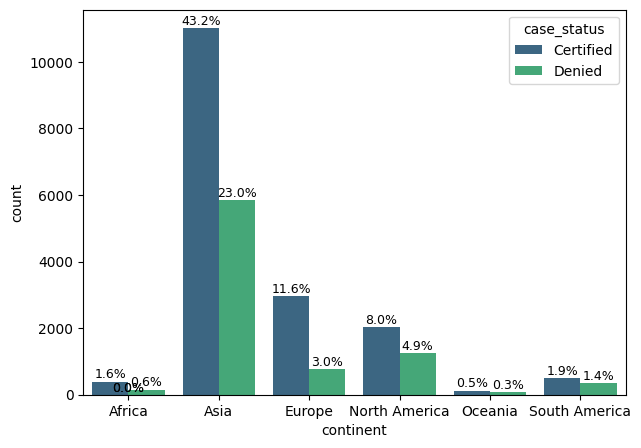

In [23]:
#create a plot of the data above, but additionally with the percent of each group within the total number of cases
labeled_barplot(df,'continent','case_status', order=None, perc=True)

3.Experienced professionals might look abroad for opportunities to improve their lifestyles and career development. Does work experience influence visa status?

In [26]:
#group data by has_job_experience and count the numbers of each case_status for each category
df.groupby('has_job_experience')['case_status'].value_counts()

has_job_experience  case_status
N                   Certified       5994
                    Denied          4684
Y                   Certified      11024
                    Denied          3778
Name: count, dtype: int64

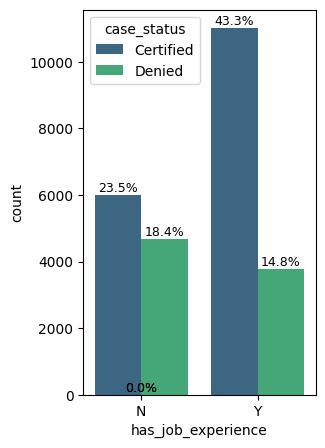

In [24]:
#create a plot of the data above, but additionally with the percent of each group within the total number of cases
labeled_barplot(df,'has_job_experience','case_status', order=None, perc=True)

Yes ,Applicants with job experience have a ratio of approved to denied applications of ~3:1, whereas the same ratio for applicants without job experience have around a 5:4 ratio (i.e., approximately equivalent).

In the United States, employees are paid at different intervals. Which pay unit is most likely to be certified for a visa?

In [27]:
#group data by unit_of_wage and count the numbers of each case_status for each category
df.groupby('unit_of_wage')['case_status'].value_counts()

unit_of_wage  case_status
Hour          Denied          1410
              Certified        747
Month         Certified         55
              Denied            34
Week          Certified        169
              Denied           103
Year          Certified      16047
              Denied          6915
Name: count, dtype: int64

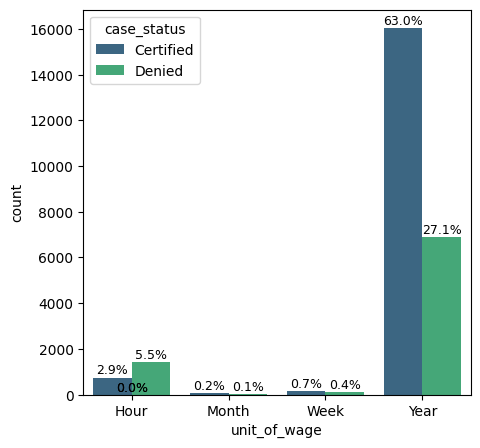

In [25]:
#create a plot of the data above, but additionally with the percent of each group within the total number of cases
labeled_barplot(df,'unit_of_wage','case_status', order=None, perc=True)

Applicants who are applying to work in a job with an hourly rate have a ratio of approved versus denied applications of ~1:2. Additionally, these applicants comprise only ~8% of all applications, but comprise ~17% of all denials.
Applicants from any other unit_of_wage category have a ratio of ~2:1, with applications for jobs with annual salaries showing nearly a 2.5:1 ratio of approvals to denials.

he US government has established a prevailing wage to protect local talent and foreign workers. How does the visa status change with the prevailing wage?

In [28]:
#group data by unit_of_wage and calculate the mean prevailing_wage for each category
df.groupby('unit_of_wage')['prevailing_wage'].mean()

,prevailing_wage
unit_of_wage,
Hour,414.57
Month,87592.86
Week,85606.82
Year,81228.08


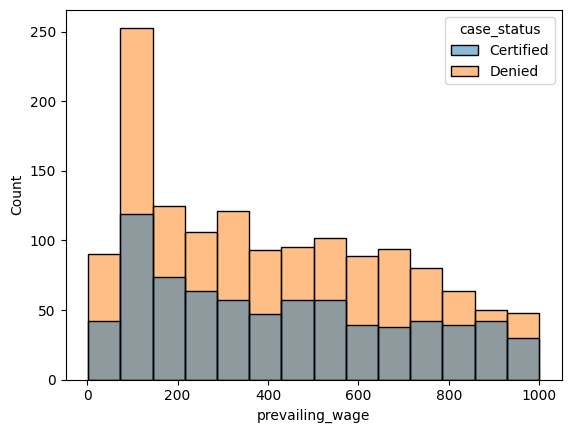

In [29]:
#create a dataframe only of workers applying for jobs with a *unit_wage* of 'Hour'
df_hourly = df[df.unit_of_wage=='Hour']
#show a distribution of the *prevailing_wage* within this dataframe, along with the ratio of *case_status* within each bin
sns.histplot(data=df_hourly, x='prevailing_wage', hue='case_status')
plt.show()

**Data Preprocessing**

In [30]:
#create bins to categorize companies by the size of their overall workforce
bins = [0,1000,2000,3000,4000,np.Inf]
names = ['0-1000','1000-2000','2000-3000','3000-4000','4000+']
#assign each applicant to a category which indicates the size of the company he or she is applying to
df['company_size'] = pd.cut(df['no_of_employees'], bins, labels=names)
df.company_size.value_counts()

,count
company_size,
0-1000,6208
1000-2000,5915
2000-3000,4978
4000+,4798
3000-4000,3548


In [31]:
#create bins to categorize companies by the number of years since the company was founded
bins = [0,1966,1986,1996,2006,np.Inf]
names = ['50+','30-50','20-30','10-20','0-10']
#assign each applicant to a category which indicates how long the company has been in business (i.e., a proxy for how well-established the company is)
df['company_age'] = pd.cut(df['yr_of_estab'], bins, labels=names)
df.company_age.value_counts()

,count
company_age,
10-20,8378
50+,5109
0-10,4856
30-50,3746
20-30,3391


In [32]:
#create bins that categorize applicants by the per-day wage of the job he or she is applying for
bins = list(np.arange(0,1100,200))
#assign each applicant to a category
df_hourly['income_per_day'] = pd.cut(df_hourly['prevailing_wage'], bins)
df_hourly.groupby('income_per_day')['case_status'].value_counts()

income_per_day  case_status
(0, 200]        Denied         448
                Certified      219
(200, 400]      Denied         301
                Certified      166
(400, 600]      Denied         274
                Certified      144
(600, 800]      Denied         239
                Certified      116
(800, 1000]     Denied         148
                Certified      102
Name: count, dtype: int64

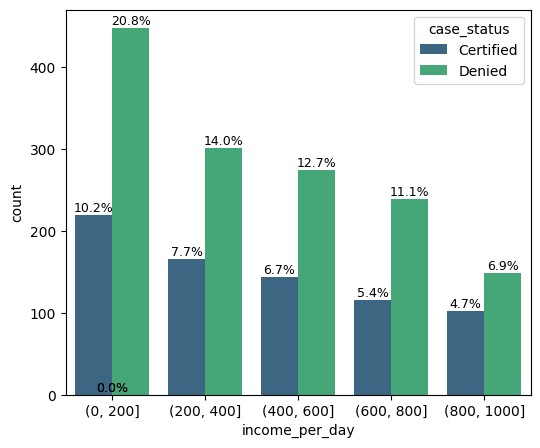

In [33]:
#create a plot of the data above, but additionally with the percent of each group within the total number of cases
labeled_barplot(df_hourly,'income_per_day','case_status',perc=True,order=None)

Bivariate Analysis

continent    Africa   Asia  Europe  North America  Oceania  South America  \
case_status                                                                 
All             551  16861    3732           3292      192            852   
Certified       397  11012    2957           2037      122            493   
Denied          154   5849     775           1255       70            359   

continent      All  
case_status         
All          25480  
Certified    17018  
Denied        8462  
------------------------------------------------------------------------------------------------------------------------


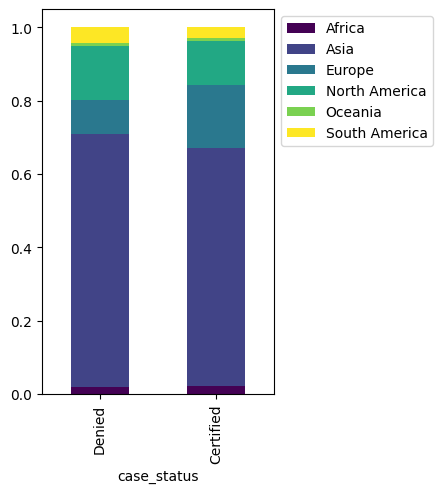

education_of_employee  Bachelor's  Doctorate  High School  Master's    All
case_status                                                               
All                         10234       2192         3420      9634  25480
Certified                    6367       1912         1164      7575  17018
Denied                       3867        280         2256      2059   8462
------------------------------------------------------------------------------------------------------------------------


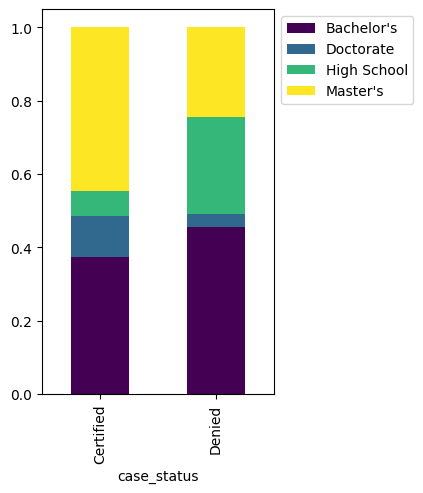

has_job_experience      N      Y    All
case_status                            
All                 10678  14802  25480
Certified            5994  11024  17018
Denied               4684   3778   8462
------------------------------------------------------------------------------------------------------------------------


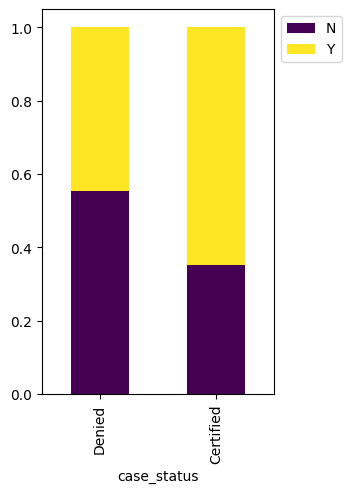

requires_job_training      N     Y    All
case_status                              
All                    22525  2955  25480
Certified              15012  2006  17018
Denied                  7513   949   8462
------------------------------------------------------------------------------------------------------------------------


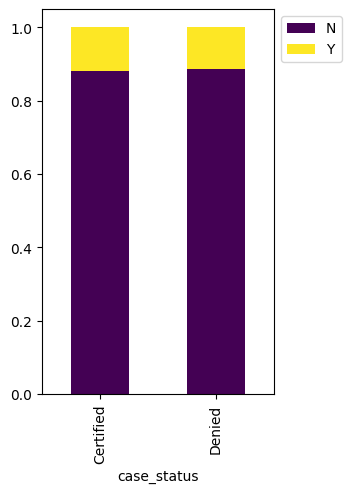

region_of_employment  Island  Midwest  Northeast  South  West    All
case_status                                                         
All                      375     4307       7195   7017  6586  25480
Certified                226     3253       4526   4913  4100  17018
Denied                   149     1054       2669   2104  2486   8462
------------------------------------------------------------------------------------------------------------------------


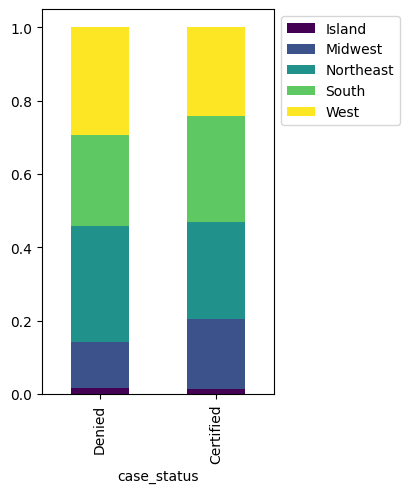

unit_of_wage  Hour  Month  Week   Year    All
case_status                                  
All           2157     89   272  22962  25480
Certified      747     55   169  16047  17018
Denied        1410     34   103   6915   8462
------------------------------------------------------------------------------------------------------------------------


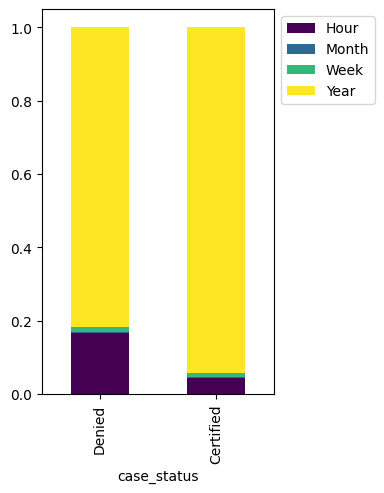

full_time_position     N      Y    All
case_status                           
All                 2707  22773  25480
Certified           1855  15163  17018
Denied               852   7610   8462
------------------------------------------------------------------------------------------------------------------------


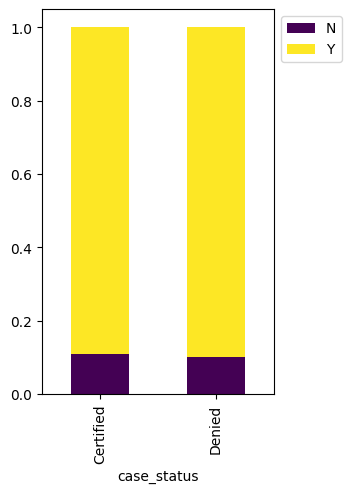

case_status  Certified  Denied    All
case_status                          
Denied               0    8462   8462
All              17018    8462  25480
Certified        17018       0  17018
------------------------------------------------------------------------------------------------------------------------


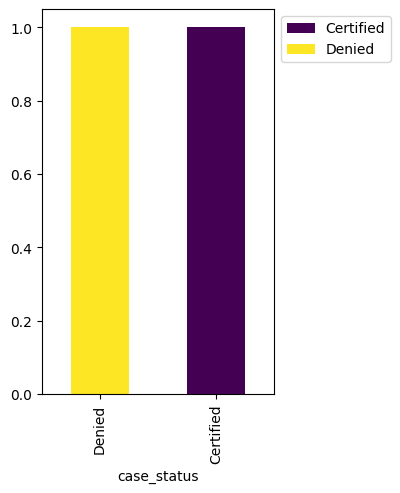

company_size  0-1000  1000-2000  2000-3000  3000-4000  4000+    All
case_status                                                        
All             6208       5915       4978       3548   4798  25447
Certified       4091       3878       3330       2341   3361  17001
Denied          2117       2037       1648       1207   1437   8446
------------------------------------------------------------------------------------------------------------------------


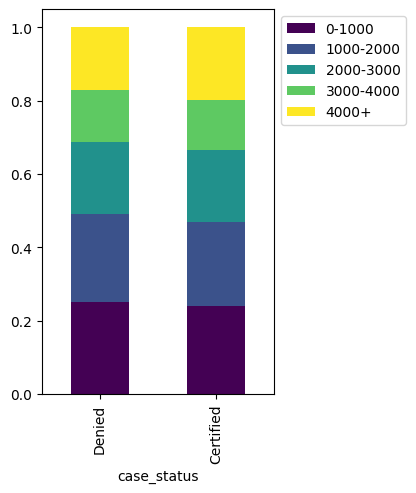

company_age   50+  30-50  20-30  10-20  0-10    All
case_status                                        
All          5109   3746   3391   8378  4856  25480
Certified    3387   2469   2230   5573  3359  17018
Denied       1722   1277   1161   2805  1497   8462
------------------------------------------------------------------------------------------------------------------------


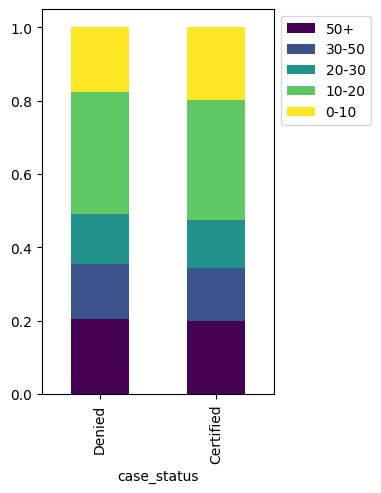

In [34]:
#create a table and stacked barplot for each variable with a data type of category by case_status
cols_cat = df.select_dtypes(['category'])
for i in cols_cat.columns:
    stacked_barplot(df, "case_status", i)

Data Preprocessing

In [38]:
#drop the int_64 columns from the dataframe, since this information is captured through the features engineered above
df_model = df.drop(labels=['no_of_employees','yr_of_estab'], axis=1, inplace=True)

Encoding Certified as 1 and Denied as 0, as the OFLC wants to identify those visa applicants who are predicted to be approved.

In [39]:
df["case_status"] = df["case_status"].apply(lambda x: 1 if x == "Certified" else 0)

Spliting the data

In [40]:
#create a dataframe of the predictor feature columns
X = df.drop('case_status',axis=1)
#create a datafrane of the predicted class (1=True, 0=False)
Y = df['case_status']

#generate dummy variables for each categorical variable
X = pd.get_dummies(X, drop_first=True)

#split the data into train and test datasets
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=1)

In [41]:
#confirm the split
print("{0:0.2f}% data is in training set".format((len(x_train)/len(df.index)) * 100))
print("{0:0.2f}% data is in test set".format((len(x_test)/len(df.index)) * 100))

70.00% data is in training set
30.00% data is in test set


In [42]:
#confirm the shape of both data sets and the ratio of classes is the same across both train and test datasets
print("Shape of Training set : ", x_train.shape)
print("Shape of test set : ", x_test.shape)
print(' ')
print("Percentage of classes in training set:")
print(y_train.value_counts(normalize=True))
print(' ')
print("Percentage of classes in test set:")
print(y_test.value_counts(normalize=True))

Shape of Training set :  (17836, 27)
Shape of test set :  (7644, 27)
 
Percentage of classes in training set:
case_status
1   0.66
0   0.34
Name: proportion, dtype: float64
 
Percentage of classes in test set:
case_status
1   0.68
0   0.32
Name: proportion, dtype: float64


**Bagging and Boosting models**

Model evaluation criterion

Model evaluation criterion
Model can make wrong predictions as:
Predicting an applicant should be approved the applicant is denied.
Predicting an applicant should be denied and the applicant is approved.
Which case is more important?
Both are important:
If an applicant is approved when they would have been denied, an unqualified employee will get a job that should have been filled by a US citizen.
If an applicant is denied when they should have been approved, U.S. companies will not be able to fill critical positions and the overall economy will not be as productive.
How to reduce the losses?
As the process of reviewing each application is time and resource-intensive, this model should identify those candidates predicted to be approved, so agents can prioritize these applications.
F1 Score can be used a the metric for evaluation of the model, as the greater the F1 score, the higher the chances of minimizing False Negatives and False Positives.
We will use balanced class weights, where applicable, so that model focuses equally on both classes.

Defining functions to provide metric scores (i.e., accuracy, recall, and precision) on the train and test datasets and to show the resulting confusion matrices.

In [43]:
# defining a function to compute different metrics to check performance of a classification model built using sklearn
def model_performance_classification_sklearn(model, predictors, target):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    """

    # predicting using the independent variables
    pred = model.predict(predictors)

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred)  # to compute Recall
    precision = precision_score(target, pred)  # to compute Precision
    f1 = f1_score(target, pred)  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {
            "Accuracy": acc,
            "Recall": recall,
            "Precision": precision,
            "F1": f1,
        },
        index=[0],
    )

    return df_perf

In [44]:
def confusion_matrix_sklearn(model, predictors, target):
    """
    To plot the confusion_matrix with percentages

    model: classifier
    predictors: independent variables
    target: dependent variable
    """
    y_pred = model.predict(predictors)
    cm = confusion_matrix(target, y_pred)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(2, 2)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt="")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

Decision Tree Model
We will build our model using the DecisionTreeClassifier function, using default 'gini' criteria to split.

In [52]:
dtree = DecisionTreeClassifier(criterion='gini', random_state=1, class_weight='balanced', ccp_alpha=0.01)

In [46]:
dtree.fit(x_train, y_train)

DecisionTreeClassifier(class_weight='balanced', random_state=1)

In [61]:
dtree =DecisionTreeClassifier(ccp_alpha=0.01, class_weight='balanced', criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0,
                       random_state=1, splitter='best')


In [63]:
# Fit the model after re-instantiating dtree
dtree.fit(x_train, y_train) # Call fit again to train the new instance of dtree

DecisionTreeClassifier(ccp_alpha=0.01, class_weight='balanced', random_state=1)

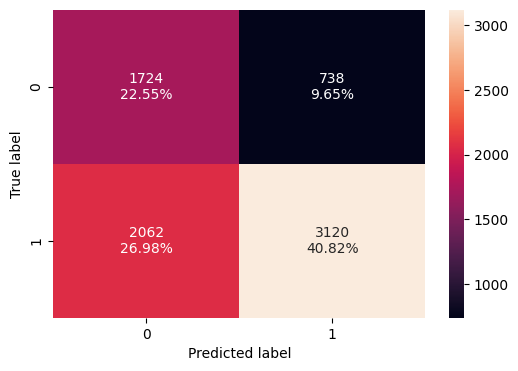

In [64]:
#create a confusion matrix of the classifier's performance on the testing data
confusion_matrix_sklearn(dtree, x_test, y_test)

Confusion Matrix -

Applicant was approved and the model predicted approval : True Positive (observed=1,predicted=1)

Applicant was denied and the model predicted approval : False Positive (observed=0,predicted=1)

Applicant was denied and the model predicted denial : True Negative (observed=0,predicted=0)

Applicant was approved and the model predicted denial : False Negative (observed=1,predicted=0)

In [65]:
dtree_model_train_perf=model_performance_classification_sklearn(dtree, x_train, y_train)
print("Training performance \n",dtree_model_train_perf)

Training performance 
    Accuracy  Recall  Precision   F1
0      0.64    0.61       0.81 0.69


In [66]:
dtree_model_test_perf=model_performance_classification_sklearn(dtree, x_test, y_test)
print("Testing performance \n",dtree_model_test_perf)

Testing performance 
    Accuracy  Recall  Precision   F1
0      0.63    0.60       0.81 0.69


The Decision Tree is working well on the training data, but is not able to generalize well on the test data, indicating the model is overfit.

Bagging Classifier

In [67]:
bagging = BaggingClassifier(random_state=1)
bagging.fit(x_train,y_train)

BaggingClassifier(random_state=1)

In [69]:
BaggingClassifier(estimator=None, bootstrap=True, bootstrap_features=False,
                  max_features=1.0, max_samples=1.0, n_estimators=10,
                  n_jobs=None, oob_score=False, random_state=1, verbose=0,
                  warm_start=False)

BaggingClassifier(random_state=1)

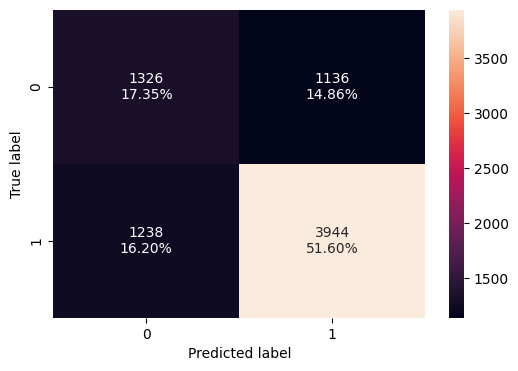

In [70]:
#create a confusion matrix of the classifier's performance on the testing data
confusion_matrix_sklearn(bagging, x_test, y_test)

In [71]:
bagging_model_train_perf=model_performance_classification_sklearn(bagging, x_train, y_train)
print("Training performance \n",bagging_model_train_perf)

Training performance 
    Accuracy  Recall  Precision   F1
0      0.98    0.98       0.99 0.99


In [72]:
bagging_model_test_perf=model_performance_classification_sklearn(bagging, x_test, y_test)
print("Testing performance \n",bagging_model_test_perf)

Testing performance 
    Accuracy  Recall  Precision   F1
0      0.69    0.76       0.78 0.77


Random Forest

In [73]:
rf = RandomForestClassifier(random_state=1)
rf.fit(x_train,y_train)

RandomForestClassifier(random_state=1)

In [75]:
rf = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

In [79]:
rf = RandomForestClassifier(random_state=1)
rf.fit(x_train,y_train)

RandomForestClassifier(random_state=1)

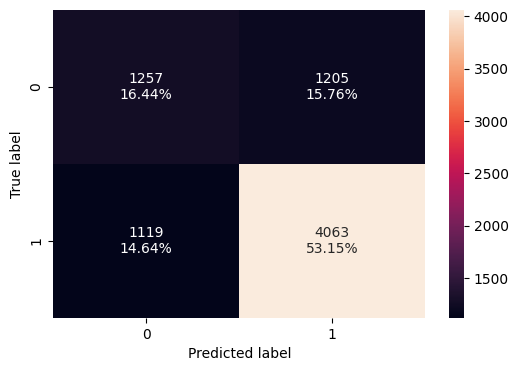

In [80]:
#create a confusion matrix of the classifier's performance on the testing data
confusion_matrix_sklearn(rf,x_test,y_test)

In [81]:
rf_model_train_perf=model_performance_classification_sklearn(rf,x_train,y_train)
print("Training performance \n",rf_model_train_perf)

Training performance 
    Accuracy  Recall  Precision   F1
0      1.00    1.00       1.00 1.00


In [82]:
rf_model_test_perf=model_performance_classification_sklearn(rf,x_test,y_test)
print("Testing performance \n",rf_model_test_perf)


Testing performance 
    Accuracy  Recall  Precision   F1
0      0.70    0.78       0.77 0.78


AdaBoost Classifier

In [83]:
ab_classifier=AdaBoostClassifier(random_state=1)
ab_classifier.fit(x_train,y_train)

AdaBoostClassifier(random_state=1)

In [85]:
AdaBoostClassifier(algorithm='SAMME.R', estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=1)

AdaBoostClassifier(random_state=1)

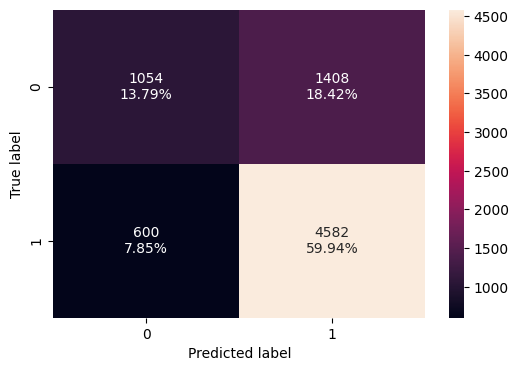

In [86]:
#create a confusion matrix of the classifier's performance on the testing data
confusion_matrix_sklearn(ab_classifier, x_test,y_test)

In [87]:
ab_classifier_model_train_perf = model_performance_classification_sklearn(ab_classifier,x_train,y_train)
print("Training performance \n",ab_classifier_model_train_perf)

Training performance 
    Accuracy  Recall  Precision   F1
0      0.74    0.88       0.76 0.82


In [88]:
ab_classifier_model_test_perf = model_performance_classification_sklearn(ab_classifier,x_test,y_test)
print("Testing performance \n",ab_classifier_model_test_perf)

Testing performance 
    Accuracy  Recall  Precision   F1
0      0.74    0.88       0.76 0.82


This AdaBoost classifer performs equally well on the training and testing datasets, indicating that the model is not overfit.
Additionally, the model performs the best of any model yet (i.e., highest F1 score) on the testing data.

Gradient Boosting Classifier

In [89]:
gbc = GradientBoostingClassifier(random_state=1)
gbc.fit(x_train,y_train)

GradientBoostingClassifier(random_state=1)

In [94]:
GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, # This parameter serves a similar purpose
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None,
                           random_state=1, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GradientBoostingClassifier(loss='deviance', random_state=1)

In [96]:
# 1. Import necessary libraries
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix

In [97]:
# 2. Create and train the model
gbc = GradientBoostingClassifier(random_state=1)
gbc.fit(x_train, y_train) # This line is crucial


GradientBoostingClassifier(random_state=1)

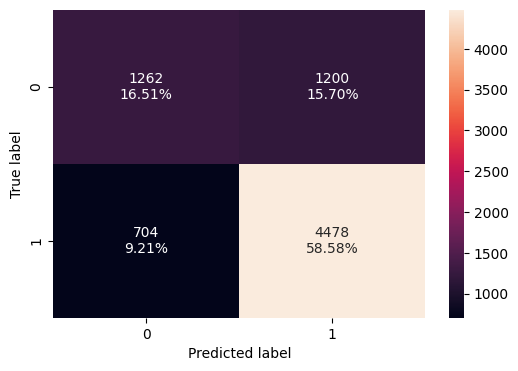

In [98]:
#create a confusion matrix of the classifier's performance on the testing data
confusion_matrix_sklearn(gbc, x_test,y_test)

In [99]:
gbc_classifier_model_train_perf = model_performance_classification_sklearn(gbc,x_train,y_train)
print("Training performance \n",gbc_classifier_model_train_perf)

Training performance 
    Accuracy  Recall  Precision   F1
0      0.75    0.87       0.78 0.83


In [100]:
gbc_classifier_model_test_perf = model_performance_classification_sklearn(gbc,x_test,y_test)
print("Training performance \n",gbc_classifier_model_test_perf)

Training performance 
    Accuracy  Recall  Precision   F1
0      0.75    0.86       0.79 0.82


This Gradient Boosting classifer performs equally well on the training and testing datasets, indicating that the model is not overfit.
Additionally, this model performs even better than the AdaBoost model above.

XGBoost Classifier

In [101]:
xgb = XGBClassifier(random_state=1,eval_metric='logloss')
xgb.fit(x_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=1, ...)

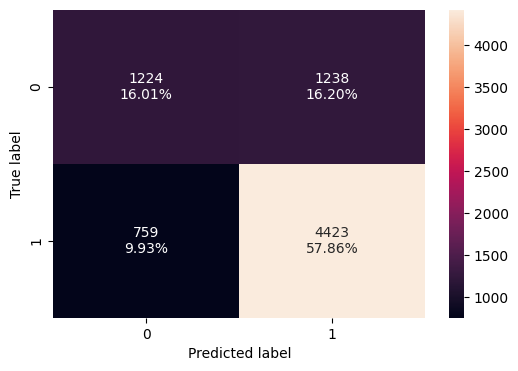

In [102]:
#create a confusion matrix of the classifier's performance on the testing data
confusion_matrix_sklearn(xgb, x_test,y_test)

In [103]:
xgb_classifier_model_train_perf = model_performance_classification_sklearn(xgb,x_train,y_train)
print("Training performance \n",xgb_classifier_model_train_perf)

Training performance 
    Accuracy  Recall  Precision   F1
0      0.82    0.91       0.83 0.87


In [104]:
xgb_classifier_model_test_perf = model_performance_classification_sklearn(xgb,x_test,y_test)
print("Training performance \n",xgb_classifier_model_test_perf)

Training performance 
    Accuracy  Recall  Precision   F1
0      0.74    0.85       0.78 0.82


his XGBoost classifer performs equally well on the training and testing datasets, indicating that the model is not overfit.
Additionally, this model performs as well as the AdaBoost model and slightly worse the Gradient Boost model on the test data.

Base models comparison

In [105]:
# create a dataframe comparing the performance of the base models on the training data

models_train_comp_df = pd.concat(
    [dtree_model_train_perf.T,
     bagging_model_train_perf.T,
     rf_model_train_perf.T,
     ab_classifier_model_train_perf.T,
     gbc_classifier_model_train_perf.T,
     xgb_classifier_model_train_perf.T],
    axis=1,
)
models_train_comp_df.columns = [
    "Decision Tree",
    "Bagging Classifier",
    "Random Forest",
    "AdaBoost Classifier",
    "Gradient Boosting Classifier",
    "XGBoost Classifier"]
print("Training performance comparison of base models:")
models_train_comp_df

Training performance comparison of base models:


,Decision Tree,Bagging Classifier,Random Forest,AdaBoost Classifier,Gradient Boosting Classifier,XGBoost Classifier
Accuracy,0.64,0.98,1.00,0.74,0.75,0.82
Recall,0.61,0.98,1.00,0.88,0.87,0.91
Precision,0.81,0.99,1.00,0.76,0.78,0.83
F1,0.69,0.99,1.00,0.82,0.83,0.87


In [106]:
# create a dataframe comparing the performance of the base models on the testing data

models_test_comp_df = pd.concat(
    [dtree_model_test_perf.T,
     bagging_model_test_perf.T,
     rf_model_test_perf.T,
     ab_classifier_model_test_perf.T,
     gbc_classifier_model_test_perf.T,
     xgb_classifier_model_test_perf.T],
    axis=1,
)
models_test_comp_df.columns = [
    "Decision Tree",
    "Bagging Classifier",
    "Random Forest",
    "AdaBoost Classifier",
    "Gradient Boosting Classifier",
    "XGBoost Classifier"]
print("Testing performance comparison of base models:")
models_test_comp_df

Testing performance comparison of base models:


,Decision Tree,Bagging Classifier,Random Forest,AdaBoost Classifier,Gradient Boosting Classifier,XGBoost Classifier
Accuracy,0.63,0.69,0.70,0.74,0.75,0.74
Recall,0.60,0.76,0.78,0.88,0.86,0.85
Precision,0.81,0.78,0.77,0.76,0.79,0.78
F1,0.69,0.77,0.78,0.82,0.82,0.82


Hyperparameter tuning

In [107]:
# Choose the type of classifier.
dtree_estimator = DecisionTreeClassifier(random_state=1)

# Grid of parameters to choose from
parameters = {'max_depth': np.arange(5,30,5),
              'min_samples_leaf': [3, 5, 7],
              'max_leaf_nodes' : [2, 4, 6],
              'min_impurity_decrease': [0.0001,0.001,0.01,0.1]
             }

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.f1_score)

# Run the grid search
grid_obj = GridSearchCV(dtree_estimator, parameters, scoring=scorer, cv=5)
grid_obj = grid_obj.fit(x_train, y_train)

# Set the clf to the best combination of parameters
dtree_estimator = grid_obj.best_estimator_

# Fit the best algorithm to the data.
dtree_estimator.fit(x_train, y_train)

DecisionTreeClassifier(max_depth=5, max_leaf_nodes=4,
                       min_impurity_decrease=0.0001, min_samples_leaf=3,
                       random_state=1)

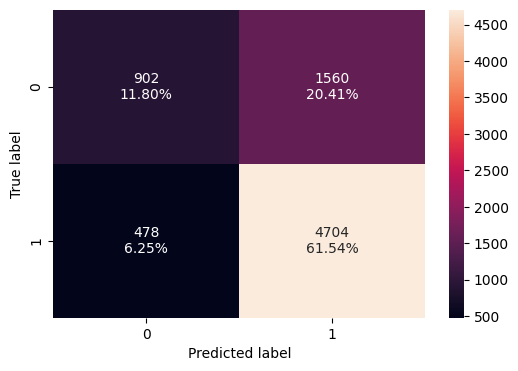

In [108]:
#create a confusion matrix of the classifier's performance on the testing data
confusion_matrix_sklearn(dtree_estimator, x_test,y_test)

In [109]:
dtree_estimator_model_train_perf=model_performance_classification_sklearn(dtree_estimator, x_train,y_train)
print("Training performance \n",dtree_estimator_model_train_perf)

Training performance 
    Accuracy  Recall  Precision   F1
0      0.73    0.91       0.74 0.81


In [110]:
dtree_estimator_model_test_perf=model_performance_classification_sklearn(dtree_estimator, x_test, y_test)
print("Testing performance \n",dtree_estimator_model_test_perf)

Testing performance 
    Accuracy  Recall  Precision   F1
0      0.73    0.91       0.75 0.82


The Decision Tree model after tuning performs equally well on the training and testing datasets, indicating that the model is not overfit.
Additionally, this model performs as well as two out of the three boosting models above on the test data.
Both of these indicate this tuned model is a significant improvements over the base model.

Tuning Bagging Classifier

Hyperparameters available for bagging classifier include:

base_estimator: The base estimator to fit on random subsets of the dataset. If None(default), then the base estimator is a decision tree.
n_estimators: The number of trees in the forest, default = 100.
max_features: The number of features to consider when looking for the best split.
bootstrap: Whether bootstrap samples are used when building trees. If False, the entire dataset is used to build each tree, default=True.
bootstrap_features: If it is true, then features are drawn with replacement. Default value is False.
max_samples: If bootstrap is True, then the number of samples to draw from X to train each base estimator. If None (default), then draw N samples, where N is the number of observations in the train data.
oob_score: Whether to use out-of-bag samples to estimate the generalization accuracy, default=False.

In [111]:
# random search for bagging classifier
parameters = {'max_samples': [0.7,0.8,0.9,1],
              'max_features': [0.7,0.8,0.9,1],
              'n_estimators' : np.arange(50, 100, 10)
             }

#run the randomized search
rand_bag = RandomizedSearchCV(BaggingClassifier(random_state=1,bootstrap=True),
                              parameters, scoring = 'f1', cv = 5, random_state=1)
rand_bag = rand_bag.fit(x_train, y_train)

# Set the clf to the best combination of parameters
bag_tuned = rand_bag.best_estimator_

# Fit the best algorithm to the data
bag_tuned.fit(x_train, y_train)

BaggingClassifier(max_features=0.8, max_samples=0.8, n_estimators=70,
                  random_state=1)

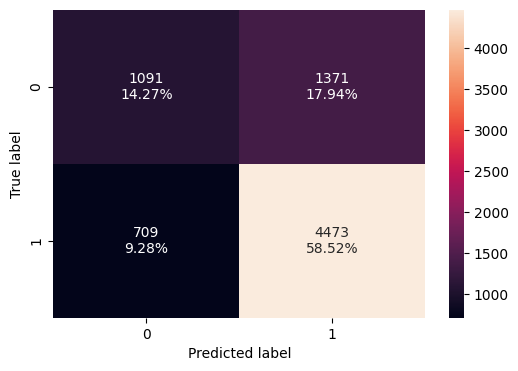

In [112]:
#create a confusion matrix of the classifier's performance on the testing data
confusion_matrix_sklearn(bag_tuned, x_test,y_test)

In [113]:
bagging_estimator_model_train_perf=model_performance_classification_sklearn(bag_tuned, x_train,y_train)
print("Training performance \n",bagging_estimator_model_train_perf)

Training performance 
    Accuracy  Recall  Precision   F1
0      0.99    1.00       0.98 0.99


In [114]:
bagging_estimator_model_test_perf=model_performance_classification_sklearn(bag_tuned, x_test, y_test)
print("Testing performance \n",bagging_estimator_model_test_perf)

Testing performance 
    Accuracy  Recall  Precision   F1
0      0.73    0.86       0.77 0.81


The Bagging Classifier after tuning performs far less well on the test data than on the training data, indicating that the model is still overfit.
However, this model does perform better than the base model.

Tuning Random Forest

Hyperparameters for Random Forest include:

n_estimators: The number of trees in the forest, default = 100.

max_features: The number of features to consider when looking for the best split.

class_weight: Weights associated with classes in the form {class_label: weight}.If not given, all classes are supposed to have weight one.

For example: If the frequency of class 0 is 80% and the frequency of class 1 is 20% in the data, then class 0 will become the dominant class and the model will become biased toward the dominant classes. In this case, we can pass a dictionary {0:0.2,1:0.8} to the model to specify the weight of each class and the random forest will give more weightage to class 1.

bootstrap: Whether bootstrap samples are used when building trees. If False, the entire dataset is used to build each tree, default=True.

max_samples: If bootstrap is True, then the number of samples to draw from X to train each base estimator. If None (default), then draw N samples, where N is the number of observations in the train data.

oob_score: Whether to use out-of-bag samples to estimate the generalization accuracy, default=False.

Note: A lot of hyperparameters of Decision Trees are also available to tune Random Forest like max_depth, min_sample_split etc.

In [115]:
# Choose the type of classifier.
rf_estimator = RandomForestClassifier(random_state=1)

# Grid of parameters to choose from
parameters = {"n_estimators": np.arange(10, 40, 10),
              "min_samples_leaf": np.arange(5, 10),
              "min_samples_split": [3, 5, 7],
              "max_features": ["sqrt", "log2"],
              "max_samples": np.arange(0.3, 0.7, 0.1),
}

# Run the randomized search
rand_rf = RandomizedSearchCV(rf_estimator, parameters, scoring='f1', cv=5, n_jobs=-1, random_state=1)
rand_rf = grid_obj.fit(x_train, y_train)

# Set the clf to the best combination of parameters
rf_estimator = rand_rf.best_estimator_

# Fit the best algorithm to the data.
rf_estimator.fit(x_train, y_train)

DecisionTreeClassifier(max_depth=5, max_leaf_nodes=4,
                       min_impurity_decrease=0.0001, min_samples_leaf=3,
                       random_state=1)

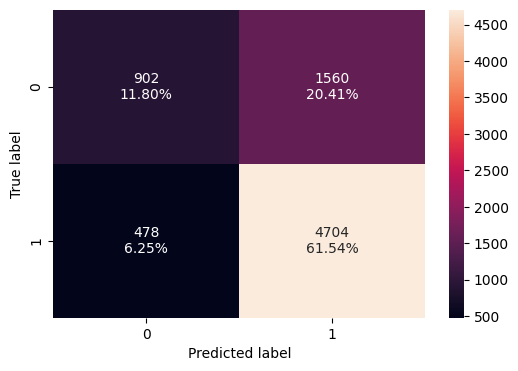

In [116]:
#create a confusion matrix of the classifier's performance on the testing data
confusion_matrix_sklearn(rf_estimator, x_test,y_test)

In [117]:
rf_estimator_model_train_perf=model_performance_classification_sklearn(rf_estimator, x_train,y_train)
print("Training performance \n",rf_estimator_model_train_perf)

Training performance 
    Accuracy  Recall  Precision   F1
0      0.73    0.91       0.74 0.81


In [118]:
rf_estimator_model_test_perf=model_performance_classification_sklearn(rf_estimator, x_test, y_test)
print("Testing performance \n",rf_estimator_model_test_perf)

Testing performance 
    Accuracy  Recall  Precision   F1
0      0.73    0.91       0.75 0.82


he Random Forest after tuning performs equally well on the training and testing datasets, indicating that the model is not overfit.
Additionally, this model performs as well as two out of the three boosting models and the tuned Decision Tree on the test data.
Both of these indicate this tuned model is a significant improvements over the base model.

Tuning AdaBoost Classifier

Hyperparameters include:

base_estimator: The base estimator from which the boosted ensemble is built. By default the base estimator is a decision tree with max_depth=1
n_estimators: The maximum number of estimators at which boosting is terminated. Default value is 50.
learning_rate: Learning rate shrinks the contribution of each classifier by learning_rate. There is a trade-off between learning_rate and n_estimators.

In [120]:
# Choose the type of classifier.
abc_tuned = AdaBoostClassifier(random_state=1)

# Grid of parameters to choose from
## add from article
parameters = {
    #Let's try different max_depth for base_estimator
    "estimator":[DecisionTreeClassifier(max_depth=1, random_state=1, class_weight='balanced'),
                      DecisionTreeClassifier(max_depth=2, random_state=1, class_weight='balanced'),
                      DecisionTreeClassifier(max_depth=3, random_state=1, class_weight='balanced')],
    "n_estimators": np.arange(10,110,10),
    "learning_rate":np.arange(0.1,2,0.1)
}

# Type of scoring used to compare parameter combinations
acc_scorer = metrics.make_scorer(metrics.f1_score)

# Run the randomized search
rand_abc = RandomizedSearchCV(abc_tuned, parameters, scoring=acc_scorer,cv=5, n_jobs=-1, random_state=1)
rand_abc = rand_abc.fit(x_train, y_train)

# Set the clf to the best combination of parameters
abc_tuned = rand_abc.best_estimator_

# Fit the best algorithm to the data.
abc_tuned.fit(x_train, y_train)

AdaBoostClassifier(estimator=DecisionTreeClassifier(class_weight='balanced',
                                                    max_depth=1,
                                                    random_state=1),
                   learning_rate=0.5, n_estimators=20, random_state=1)

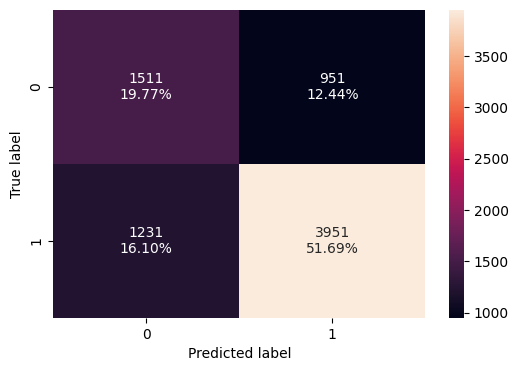

In [121]:
#create a confusion matrix of the classifier's performance on the testing data
confusion_matrix_sklearn(abc_tuned, x_test,y_test)

In [122]:
abc_tuned_model_train_perf=model_performance_classification_sklearn(abc_tuned, x_train,y_train)
print("Training performance \n",abc_tuned_model_train_perf)

Training performance 
    Accuracy  Recall  Precision   F1
0      0.72    0.76       0.80 0.78


In [123]:
abc_tuned_model_test_perf=model_performance_classification_sklearn(abc_tuned, x_test, y_test)
print("Testing performance \n",abc_tuned_model_test_perf)

Testing performance 
    Accuracy  Recall  Precision   F1
0      0.71    0.76       0.81 0.78


Performance is accurate

Tuning GradientBoost Classifier
Most of the hyperparameters available match those of a random forest classifier.

init: An estimator object that is used to compute the initial predictions. If ‘zero’, the initial raw predictions are set to zero. By default, a DummyEstimator predicting the classes priors is used.
There is no class_weights parameter in gradient boosting.

In [124]:
# Choose the type of classifier.
gb_tuned = GradientBoostingClassifier(random_state=1)

# Grid of parameters to choose from
parameters = {"n_estimators": [150,200,250,300],
              "subsample":[0.8,0.9,1],
              "max_features":[0.7,0.8,0.9,1],
              "learning_rate": np.arange(0.1, 0.4, 0.1)}

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.f1_score)

# Run the randomized search
rand_gb = RandomizedSearchCV(gb_tuned, parameters, scoring=scorer,cv=5, n_jobs=-1, random_state=1)
rand_gb = rand_gb.fit(x_train, y_train)

# Set the clf to the best combination of parameters
gb_tuned = rand_gb.best_estimator_

# Fit the best algorithm to the data.
gb_tuned.fit(x_train, y_train)

GradientBoostingClassifier(max_features=0.7, n_estimators=300, random_state=1,
                           subsample=1)

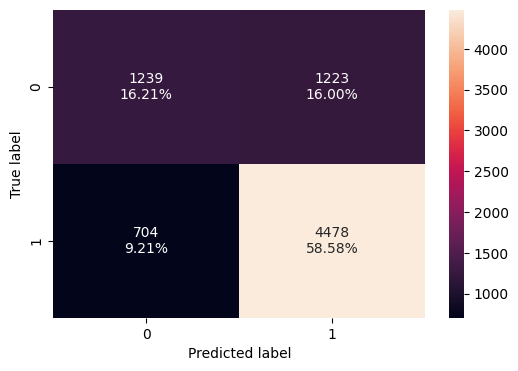

In [125]:
#create a confusion matrix of the classifier's performance on the testing data
confusion_matrix_sklearn(gb_tuned, x_test,y_test)

In [126]:
gb_tuned_model_train_perf=model_performance_classification_sklearn(rf_estimator, x_train,y_train)
print("Training performance \n",gb_tuned_model_train_perf)

Training performance 
    Accuracy  Recall  Precision   F1
0      0.73    0.91       0.74 0.81


In [127]:
gb_tuned_model_test_perf=model_performance_classification_sklearn(rf_estimator, x_test, y_test)
print("Testing performance \n",gb_tuned_model_test_perf)

Testing performance 
    Accuracy  Recall  Precision   F1
0      0.73    0.91       0.75 0.82


The Gradient Boosting classifier after tuning performs equally well on the training and testing datasets, indicating that the model is not overfit.
However, this model performs slightly worse than the base model on both the train and test data.

Tuning XGB Classifer

In [128]:
# Choose the type of classifier.
xgb_tuned = XGBClassifier(random_state=1, eval_metric='logloss')

# Grid of parameters to choose from
parameters = {"n_estimators": np.arange(10,100,20),
              "scale_pos_weight":[0,1,2,5],
              "subsample":[0.5,0.7,0.9,1],
              "learning_rate":[0.01,0.1,0.2,0.05],
              "gamma":[0,1,3],
              "colsample_bytree":[0.5,0.7,0.9,1],
              "colsample_bylevel":[0.5,0.7,0.9,1]}

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.f1_score)

# Run the randomized search
rand_xgb = RandomizedSearchCV(xgb_tuned, parameters, scoring=scorer,cv=5, n_jobs=-1, random_state=1)
rand_xgb = rand_xgb.fit(x_train, y_train)

# Set the clf to the best combination of parameters
xgb_tuned = rand_xgb.best_estimator_

# Fit the best algorithm to the data.
xgb_tuned.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=1, colsample_bynode=None, colsample_bytree=0.7,
              device=None, early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None, gamma=3,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=90, n_jobs=None,
              num_parallel_tree=None, random_state=1, ...)

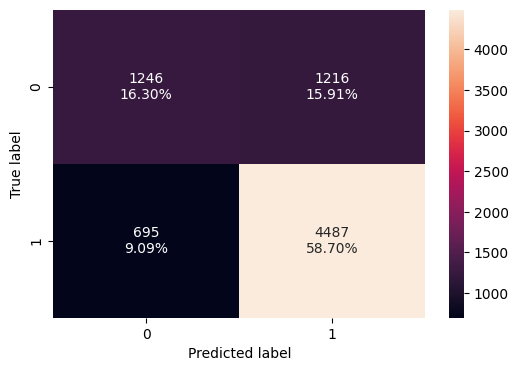

In [129]:
confusion_matrix_sklearn(xgb_tuned, x_test,y_test)

In [130]:
xgb_tuned_model_train_perf=model_performance_classification_sklearn(xgb_tuned, x_train,y_train)
print("Training performance \n",xgb_tuned_model_train_perf)

Training performance 
    Accuracy  Recall  Precision   F1
0      0.76    0.88       0.79 0.83


In [131]:
xgb_tuned_model_test_perf=model_performance_classification_sklearn(xgb_tuned, x_test, y_test)
print("Testing performance \n",xgb_tuned_model_test_perf)

Testing performance 
    Accuracy  Recall  Precision   F1
0      0.75    0.87       0.79 0.82


he XGBoost classifier after tuning is less overfit than the base model, but performs equally well on the test data.
This indicates a minor improvement over the base model.

Tuned models comparison

In [132]:
# create a dataframe comparing the performance of the tuned models on the training data

tuned_models_train_comp_df = pd.concat(
    [dtree_estimator_model_train_perf.T,
     bagging_estimator_model_train_perf.T,
     rf_estimator_model_train_perf.T,
     abc_tuned_model_train_perf.T,
     gb_tuned_model_train_perf.T,
     xgb_tuned_model_train_perf.T],
    axis=1,
)
tuned_models_train_comp_df.columns = [
    "Tuned Decision Tree",
    "Tuned Bagging Classifier",
    "Tuned Random Forest",
    "Tuned AdaBoost Classifier",
    "Tuned Gradient Boosting Classifier",
    "Tuned XGBoost Classifier"]
print("Training performance comparison of tuned models:")
tuned_models_train_comp_df

Training performance comparison of tuned models:


,Tuned Decision Tree,Tuned Bagging Classifier,Tuned Random Forest,Tuned AdaBoost Classifier,Tuned Gradient Boosting Classifier,Tuned XGBoost Classifier
Accuracy,0.73,0.99,0.73,0.72,0.73,0.76
Recall,0.91,1.00,0.91,0.76,0.91,0.88
Precision,0.74,0.98,0.74,0.80,0.74,0.79
F1,0.81,0.99,0.81,0.78,0.81,0.83


In [133]:
# create a dataframe comparing the performance of the tuned models on the testing data

tuned_models_test_comp_df = pd.concat(
    [dtree_estimator_model_test_perf.T,
     bagging_estimator_model_test_perf.T,
     rf_estimator_model_test_perf.T,
     abc_tuned_model_test_perf.T,
     gb_tuned_model_test_perf.T,
     xgb_tuned_model_test_perf.T],
    axis=1,
)
tuned_models_test_comp_df.columns = [
    "Tuned Decision Tree",
    "Tuned Bagging Classifier",
    "Tuned Random Forest",
    "Tuned AdaBoost Classifier",
    "Tuned Gradient Boosting Classifier",
    "Tuned XGBoost Classifier"]
print("Testing performance comparison of tuned models:")
tuned_models_test_comp_df

Testing performance comparison of tuned models:


,Tuned Decision Tree,Tuned Bagging Classifier,Tuned Random Forest,Tuned AdaBoost Classifier,Tuned Gradient Boosting Classifier,Tuned XGBoost Classifier
Accuracy,0.73,0.73,0.73,0.71,0.73,0.75
Recall,0.91,0.86,0.91,0.76,0.91,0.87
Precision,0.75,0.77,0.75,0.81,0.75,0.79
F1,0.82,0.81,0.82,0.78,0.82,0.82


Model Performance Comparison

In [134]:
# create a dataframe comparing the performance all models on the training data
all_models_train_comp = pd.concat([models_train_comp_df,tuned_models_train_comp_df],axis=1)
all_models_train_comp.T.sort_values('F1',ascending=False)

,Accuracy,Recall,Precision,F1
Random Forest,1.00,1.00,1.00,1.00
Tuned Bagging Classifier,0.99,1.00,0.98,0.99
Bagging Classifier,0.98,0.98,0.99,0.99
XGBoost Classifier,0.82,0.91,0.83,0.87
Tuned XGBoost Classifier,0.76,0.88,0.79,0.83
Gradient Boosting Classifier,0.75,0.87,0.78,0.83
AdaBoost Classifier,0.74,0.88,0.76,0.82
Tuned Decision Tree,0.73,0.91,0.74,0.81
Tuned Random Forest,0.73,0.91,0.74,0.81
Tuned Gradient Boosting Classifier,0.73,0.91,0.74,0.81


'The best performing model on the training data is the Decision Tree'

In [135]:
# create a dataframe comparing the performance of all models on the testing data
all_models_test_comp = pd.concat([models_test_comp_df,tuned_models_test_comp_df],axis=1)
all_models_test_comp.T.sort_values('F1',ascending=False)

,Accuracy,Recall,Precision,F1
Gradient Boosting Classifier,0.75,0.86,0.79,0.82
Tuned XGBoost Classifier,0.75,0.87,0.79,0.82
Tuned Decision Tree,0.73,0.91,0.75,0.82
Tuned Random Forest,0.73,0.91,0.75,0.82
Tuned Gradient Boosting Classifier,0.73,0.91,0.75,0.82
AdaBoost Classifier,0.74,0.88,0.76,0.82
XGBoost Classifier,0.74,0.85,0.78,0.82
Tuned Bagging Classifier,0.73,0.86,0.77,0.81
Tuned AdaBoost Classifier,0.71,0.76,0.81,0.78
Random Forest,0.70,0.78,0.77,0.78


from matplotlib import pyplot as plt
_df_0['Accuracy'].plot(kind='hist', bins=20, title='Accuracy')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['Recall'].plot(kind='hist', bins=20, title='Recall')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['Precision'].plot(kind='hist', bins=20, title='Precision')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['F1'].plot(kind='hist', bins=20, title='F1')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='Accuracy', y='Recall', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='Recall', y='Precision', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='Precision', y='F1', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7['Accuracy'].plot(kind='line', figsize=(8, 4), title='Accuracy')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_8['Recall'].plot(kind='line', figsize=(8, 4), title='Recall')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_9['Precision'].plot(kind='line', figsize=(8, 4), title='Precision')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_10['F1'].plot(kind='line', figsize=(8, 4), title='F1')
plt.gca().spines[['top', 'right']].set_visible(False)

The best performing model on the testing data is the Gradient Boosting Classifier'

eature importance of: Gradient Boosting Classifier

In [136]:
"""The importance of features in the tree building
(The importance of a feature is computed as the (normalized) total
reduction of the criterion brought by that feature.)"""

print(pd.DataFrame(gbc.feature_importances_, columns = ["Imp"],
                   index = x_train.columns).sort_values(by = 'Imp', ascending = False).head(10))

                                   Imp
education_of_employee_High School 0.27
has_job_experience_Y              0.18
prevailing_wage                   0.14
education_of_employee_Master's    0.09
education_of_employee_Doctorate   0.08
continent_Europe                  0.06
unit_of_wage_Year                 0.05
region_of_employment_Midwest      0.02
continent_North America           0.02
region_of_employment_West         0.02


In [137]:
feature_names = x_train.columns

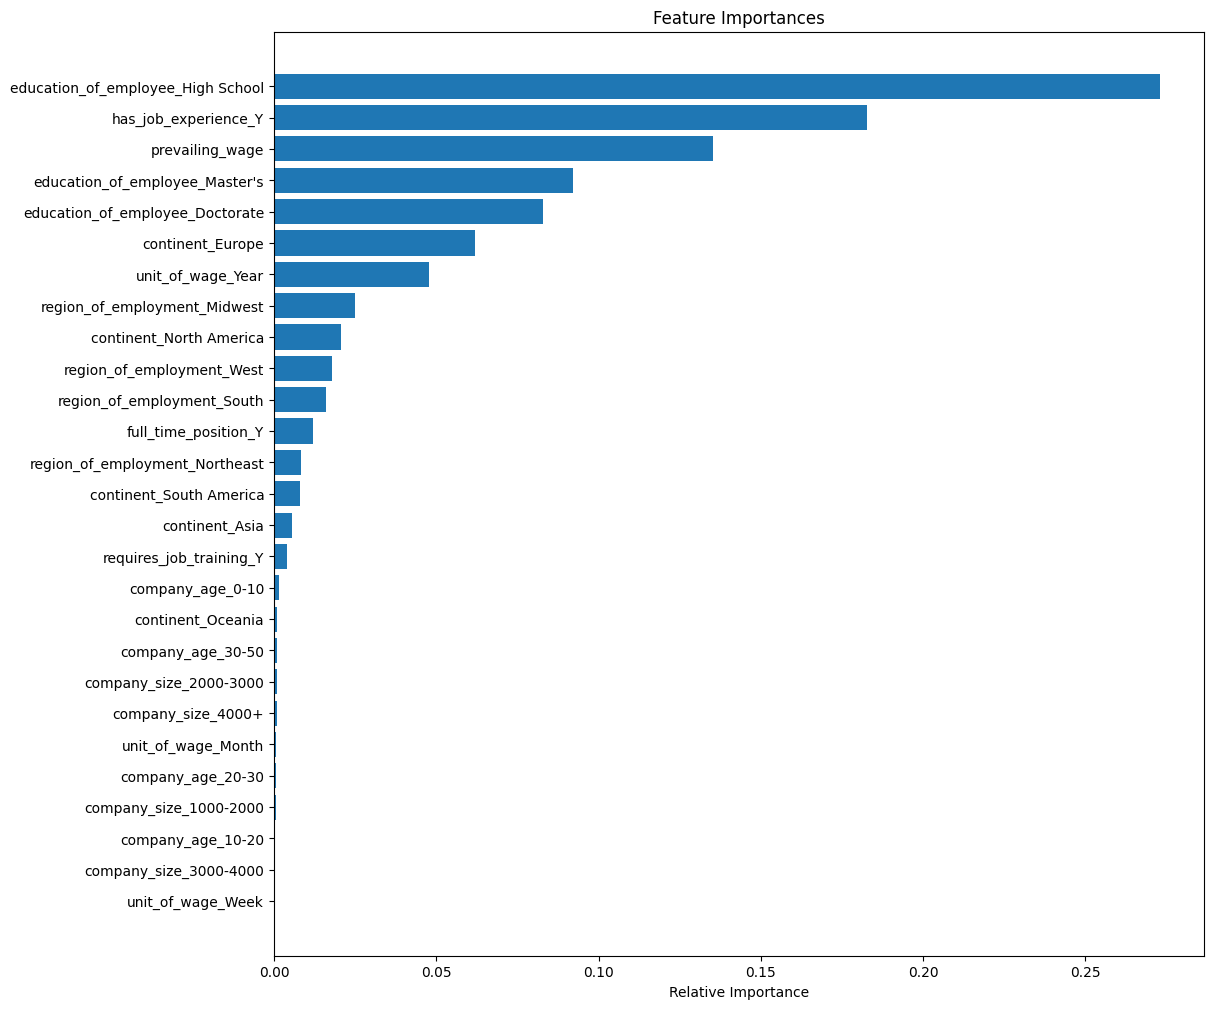

In [138]:
importances = gbc.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

Visualization of Decision Tree (tuned)

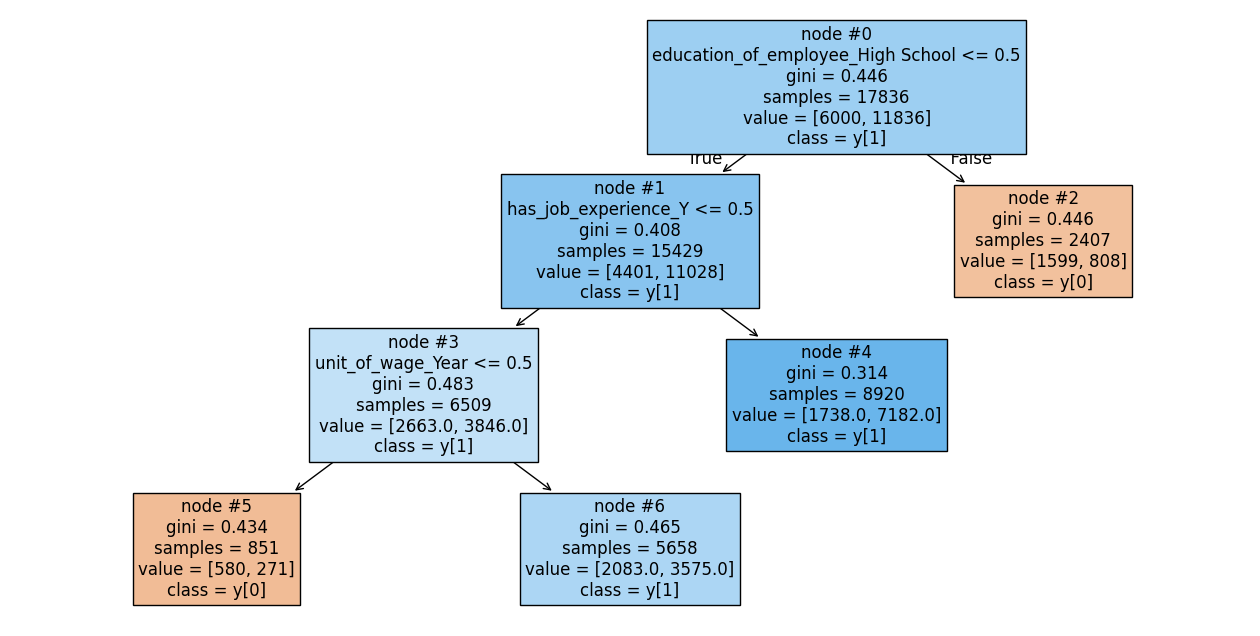

In [139]:
#create visualization of tuned decision-tree model
feature_names = list(X.columns)
plt.figure(figsize=(16,8))
tree.plot_tree(dtree_estimator,feature_names=feature_names,filled=True,fontsize=12,node_ids=True,class_names=True)
plt.show()

Conclusions
Insights
For the Office of Foreign Labor Certification (OFLC), the three most critical components for pre-screening an applicant are:

Education level
An applicant applying for a job requiring a high school diploma will more than likely be denied. Conversely, applications for jobs requiring a Master's degree or doctorate are very likely to be approved.
Prior job experience
An applicant applying for a job without any previous job experience is more likley to be denied than an applicant for a job with experience.
Prevailing wage
The higher the prevailing wage of the job an applicant is applying for, the more likely the application will be approved. This is especially true for applications for jobs with an hourly unit of wage.
Recommendations
To prioritize limited resources towards screening a batch of applications for those most likely to be approved, the OFLC can:
Sort applications by level of education and review the higher levels of education first.
Sort applications by previous job experience and review those with experience first.
Divide applications for jobs into those with an hourly wage and those with an annual wage, sort each group by the prevailing wage, then review applications for salaried jobs first from highest to lowest wage.
As stated previously, the Gradient Boosting classifier performs the best of all the models created. However, as shown above, the tuned Decision-Tree model performs barely worse by F1 score and is a far simpler model. This model may be preferable if post-hoc explanations of OFLC decision-making is expected to be required.
Furthermore, OFLC should examine more thoroughly why whether an application will be certified or denied can be very well predicted through just three nodes as shown above.
For those in less skilled, entry-level, and/or hourly jobs, the system would appear to be biased against these applications being certified.